<div style="text-align: right"> Danial Ludwig </div>
<div style="text-align: right"> University of Maryland, College Park</div>

# Comparisons of CRLB, pseudo-CRLB, and Monte Carlo simulations

The first section compares the CRLB and pseudo-CRLB. The second section compares these to the sample variance of Monte Carlo simulations.

------------------------------------------------------

## Load data, model, functions

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
np.set_printoptions(precision=4, suppress=True)

In [2]:
# data generated by make_data script
with np.load('nn-inverse-data.npz') as data:
    x_train = data['x_train']
    x_test = data['x_test']
    y_train = data['y_train']
    y_test = data['y_test']
    A = data['A']
    
# models trained in train_*_network scripts
model = tf.keras.models.load_model('model')

In [3]:
def plot_img_comparison(mat0, mat1, map_from_01=False, left_title='', right_title=''):
    '''
    Plot two matrices as images side-by-side with a shared color map.
    
    If map_from_01=True, (0,1) -> (black, white)
    If map_from_01=False, (min(both images), max(both images)) -> (black, white)
    '''
    fig, axs = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True)
    axs[0].set_title(left_title)
    axs[1].set_title(right_title)
    
    # if the domain of the images is within [0,1], then 0 -> black, 1 -> white
    if map_from_01:
        im0 = axs[0].imshow(mat0, cmap='gray', vmin=0, vmax=1)
        im1 = axs[1].imshow(mat1, cmap='gray', vmin=0, vmax=1)

        # set colorbar in-between images
        fig.colorbar(im0, ax=axs[0])

    # shared scale of overall_min -> black, overall_max -> white
    else:
        overall_min = np.min([np.min(mat0),np.min(mat1)])
        overall_max = np.max([np.max(mat0),np.max(mat1)])
        
        im0 = axs[0].imshow(mat0, cmap='gray', vmin=overall_min, vmax=overall_max)
        im1 = axs[1].imshow(mat1, cmap='gray', vmin=overall_min, vmax=overall_max)

        fig.colorbar(im0, ax=axs[0])
    plt.show()

In [4]:
def mean_abs_norm(A):
    return np.mean(np.abs(A))

def rms_norm(A):
    return np.mean(A**2)**0.5

def operator_norm(A):
    return np.max(np.linalg.svd(A, compute_uv=False))

In [5]:
@tf.function
def batchJ(x, model):
    # x is a tf.Variable with N vectors of length n
    with tf.GradientTape() as tape:
        y = model(x)
    # if each output vector in y has length d then each
    # batch of Jacobians has shape N x d x n
    return tape.batch_jacobian(y, x)

In [31]:
@tf.function
def batch_diag_JJt(x,model):
    # x is a tf.Variable with N vectors of length n
    with tf.GradientTape() as tape:
        y = model(x)
    # if each output vector in y has length d then each
    # batch of Jacobians has shape N x d x n
    jacobians = tape.batch_jacobian(y, x)
    # the diagonal of JJt can be obtained via summing along
    # the third axis (size n) of the elementwise square
    # of the Jacobian. The batch of JJt diagonals will 
    # be size N x d 
    return tf.reduce_sum(jacobians**2, axis=2)

## CRLB and pseudo-CRLB
Want to estimate $\mathbf{y} \in \mathbb{R}^{100}$ from data $\mathbf{x} \in \mathbb{R}^{500}$, where $\mathbf{x} \sim F(\mathbf{y}^TA,\sigma^2) \Rightarrow$ Fisher information matrix $I = AA^T/\sigma^2$. The trained neural network $F$ outputs an estimate $\hat{\mathbf{y}} = F(\mathbf{x})$; assuming that this estimate is not "very" biased, i.e. $E[\hat{\mathbf{y}} = F(\mathbf{x})] \approx \mathbf{y}$, have CRLB 

$$ \text{var}(\hat{\mathbf{y}}) \geq  \text{diag}[\sigma^2 (AA^T)^{-1}]$$

Assuming perfect reconstruction in the absence of noise, should have the Jacobian $J$ (100x500) of the network satisfy $J(\mathbf{y})J(\mathbf{y})^T \geq (AA^T)^{-1}$. Note that if $J(\mathbf{y})^T = A_p = A^T (AA^T)^{-1}$ (the right pseudo-inverse of A, 500x100), then equality is reached. The main goal here is to see if we can, at least approximately, use a "pseudo-CRLB"

$$ \text{var}(\hat{\mathbf{y}}) \geq  \text{diag}[\sigma^2 J(\mathbf{y})J(\mathbf{y})^T]$$

### Jacobian $J$ and pseudo-inverse $A_p$

In [60]:
# (right) pseudo-inverse of 100x500 encoding matrix A
Ap = np.linalg.pinv(A) # 500x100

# calculate first 10 Jacobians on test data (amounts to a random sample)
x_in = x_test[0:10]
Js = batchJ(tf.Variable(x_in), model).numpy()

In [59]:
# numerical comparison
idx = 9
print(f'MAE of Ap: {mean_abs_norm(Ap):.2}')
print(f'MAE of J.T: {mean_abs_norm(Js[idx].T):.2}')
print(f'MAE of Ap - J.T: {mean_abs_norm(Js[idx].T - Ap):.2}')
print('----------------------------')
print(f'RMS of Ap: {rms_norm(Ap):.2}')
print(f'RMS of J.T: {rms_norm(Js[idx].T):.2}')
print(f'RMS of Ap - J.T: {rms_norm(Js[idx].T - Ap):.2}')

MAE of Ap: 0.0018
MAE of J.T: 0.0019
MAE of Ap - J.T: 0.00051
----------------------------
RMS of Ap: 0.0022
RMS of J.T: 0.0023
RMS of Ap - J.T: 0.00064


For all 10 of these sampled $J$s, $\frac{||J^T-A_p||}{||A_p||} \sim \frac{1}{3}$, which shows they're somewhat close. Next steps:
1. $J$ seems to be mostly constant over the training and test data, but more testing both with these datasets and beyond should be done.
2. Use the operator norm to quantify how good of a general right-inverse $J$ is of $A$, regardless of whether it's close to the pseudo-inverse.

### diag$(JJ^T)$ and diag$[(AA^T)^{-1}]$

In [33]:
# (right) pseudo-inverse of 100x500 encoding matrix A
AAt_inv= np.linalg.inv(A @ A.T) # 100x100
diag_AAt_inv = np.diag(AAt_inv) # 1x100

# calculate first 10 Jacobians on test data (amounts to a random sample)
x_in = x_test[0:10]
diags_JJt = batch_diag_JJt(tf.Variable(x_in), model).numpy()

In [44]:
# numerical comparison
idx = 3 # from 0 to 9
print(f'Mean absolute norm of (AA.T)^-1: {mean_abs_norm(diag_AAt_inv):.2}')
print(f'Mean absolute norm of JJ.T: {mean_abs_norm(diags_JJt[idx]):.2}')
print(f'MAE between (AA.T)^-1 and JJ.T: {mean_abs_norm(diag_AAt_inv - diags_JJt[idx]):.2}')
print('----------------------------')
print(f'RMS of (AA.T)^-1: {rms_norm(diag_AAt_inv):.2}')
print(f'RMS JJ.T: {rms_norm(diags_JJt[idx]):.2}')
print(f'RMSE between (AA.T)^-1 and JJ.T: {rms_norm(diag_AAt_inv - diags_JJt[idx]):.2}')

Mean absolute norm of (AA.T)^-1: 0.0025
Mean absolute norm of JJ.T: 0.0027
MAE between (AA.T)^-1 and JJ.T: 0.00023
----------------------------
RMS of (AA.T)^-1: 0.0025
RMS JJ.T: 0.0027
RMSE between (AA.T)^-1 and JJ.T: 0.00023


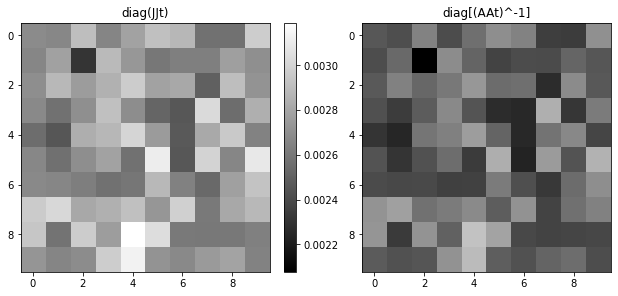

In [48]:
# visual comparison
idx = 8
diag_JJt_img = np.reshape(diags_JJt[idx], (10,10))
diag_AAt_inv_img = np.reshape(diag_AAt_inv, (10,10))
plot_img_comparison(diag_JJt_img, diag_AAt_inv_img,
                    left_title='diag(JJt)', right_title='diag[(AAt)^-1]')

Although $||\text{diag}(JJ^T)-\text{diag}[(AA^T)^{-1}]|| \sim ||\text{diag}[(AA^T)^{-1}]||$, visually they clearly have the same structure. Next steps:
1. Calculate correlations between the diagonals, since it seems like diag$(JJ^T)$ just has a higher baseline/mean/DC than diag$[(AA^T)^{-1}]$, while their relative structures are the same.

## Monte Carlo noise simulations
The function below takes an original vector $\mathbf{y}$ (possibly from the training or test datasets), encodes it with $A$, adds $N$ different realizations of Gaussian noise (with $\sigma$ specified as a fraction of the maximum of the encoded vector), then runs the clean and $N$ noisy encoded vectors through the network. The mean, bias, and sample variance are calculated from these "reconstructed" vectors; the CRLB (which depends on $\sigma$) and pseudo-CRLB (which depends on both $\sigma$ and $\mathbf{y}$) are also output.

The visual comparison of diag$(JJ^T)$ and diag$[(AA^T)^{-1}]$ above showed that if the the sample variance resembles the CRLB, then it will probably resemble the pseudo-CRLB too. The reasons why the sample variance might not resemble the CRLB are
1. The approximation of the network as "not very biased" doesn't hold.
2. The above approximation may possibly be alright, but the sample variance doesn't achieve the bound.

The hierarchy of similarity between the CRLB/pseudo-CRLB and sample variance:
1. Small norm
2. Visually similar / positive correlation over one image.
3. Positive correlation over corresponding pixels in many images

In [65]:
def monte_carlo_noise_sim(y_orig, A, model, noise_lvl, N):
    '''
    Run a Monte Carlo simulation on a neural network.
    
    Encodes y_orig with matrix A, adds N realizations of WGN to
    encoded vector (i.e. in k-space) with variance = noise_lvl * max(y_orig @ A), 
    and then runs through NN inverse model.
    
    Returns dict with fields:
        sigma: standard deviation of WGN added in k-space (1x1)
        y_clean_recon: NN output of clean encoded y_orig (1x100)
        ys_noisy_recon: NN outputs of encoded y_orig + noise (Nx100)
        y_noisy_mean: mean(ys_noisy_recon) (1x100)
        bias: y_noisy_mean - y_orig (1x100)
        variance: sample variance of ys_noisy_recon (1x100)
        crlb: sigma^2 * (A @ A.T)^-1 (100x100)
        pseudo_crlb: sigma^2 * J @ J.T evaluated at y_orig @ A (100x100)
    '''
    # y (1x100) -- A --> x (1x500)
    #          <-- NN --        
    x_clean = np.reshape(y_orig @ A, (1,500)) # Tensorflow needs 2D input
    
    # define variance of noise to be fraction of maximum of encoded vector
    sigma = np.sqrt(noise_lvl*np.max(x_clean))
    crlb = sigma**2 * np.linalg.inv(A @ A.T)

    # add N realizations of WGN
    noise_realizations = sigma*np.random.randn(N, 500)
    xs_noisy = x_clean + noise_realizations # broadcasted

    # feed through network to reconstruct. Note that imperfect reconstruction
    # implies that y_orig =/= y_clean_recon
    y_clean_recon = model(x_clean) # 1 X 100
    ys_noisy_recon = model(xs_noisy) # N x 100
    
    # take average to get best estimate of y_orig based on ys_noisy_recon
    # Note that nonlinear reconstruction implies that
    # E[y_noisy_estimate] =/= y_clean_recon
    y_noisy_mean = np.mean(ys_noisy_recon, axis=0)
    
    # sample bias and sample variance
    bias = y_noisy_mean - y_orig 
    variance = 1/(N-1) * np.sum((ys_noisy_recon - y_noisy_mean)**2, axis=0)
    
    # get jacobian and reshape from 1x100x500 -> 100x500
    jacobian = np.reshape(batchJ(tf.Variable(x_clean), model), (100,500))
    pseudo_crlb = sigma**2 * jacobian @ jacobian.T
    
    # compile results
    results = {'sigma': sigma,
               'y_clean_recon': y_clean_recon,
               'ys_noisy_recon': ys_noisy_recon,
               'y_noisy_mean': y_noisy_mean,
               'bias': bias,
               'variance': variance,
               'crlb': crlb,
               'pseudo_crlb': pseudo_crlb}
    return results

### Reconstruction vs. noise error
Roughly, the reconstruction error contributes more to the bias when $\sigma^2 < 0.1\text{max}(\mathbf{y}^TA)$, but the noise error takes over for $\sigma^2 > 0.1\text{max}(\mathbf{y}^TA)$.

Next steps:
1. For a large enough sample size $N$, plot the bias, reconstruction error, and noise error vs. the noise level.
2. Compare bias$^2$ to sample variance in a similar way.

In [73]:
# run simulation on a vector in test dataset
y_orig = y_test[0]
results = monte_carlo_noise_sim(y_orig, A, model, noise_lvl=0.05, N=2000)

In [74]:
# numerically compare original image, cleanly reconstructed image, and
# mean of noisily reconstructed images
bias = results['bias'] # y_noisy_mean - y_orig
recon_error = results['y_clean_recon'] - y_orig
noise_error = results['y_noisy_mean']  - results['y_clean_recon'] 

print(f'MAE of bias (y_noisy_mean-y_orig): {mean_abs_norm(bias):.2}')
print(f'MAE of reconstruction error (y_clean_recon-y_orig): {mean_abs_norm(recon_error):.2}')
print(f'MAE of noise error (y_noisy_mean-y_clean_recon: {mean_abs_norm(noise_error):.2}')
print('----------------------------')
print(f'RMS of bias (y_noisy_mean-y_orig): {rms_norm(bias):.2}')
print(f'RMS of reconstruction error (y_clean_recon-y_orig): {rms_norm(recon_error):.2}')
print(f'RMS of noise error (y_noisy_mean-y_clean_recon: {rms_norm(noise_error):.2}')

MAE of bias (y_noisy_mean-y_orig): 0.0038
MAE of reconstruction error (y_clean_recon-y_orig): 0.0037
MAE of noise error (y_noisy_mean-y_clean_recon: 0.0021
----------------------------
RMS of bias (y_noisy_mean-y_orig): 0.0047
RMS of reconstruction error (y_clean_recon-y_orig): 0.0046
RMS of noise error (y_noisy_mean-y_clean_recon: 0.0026


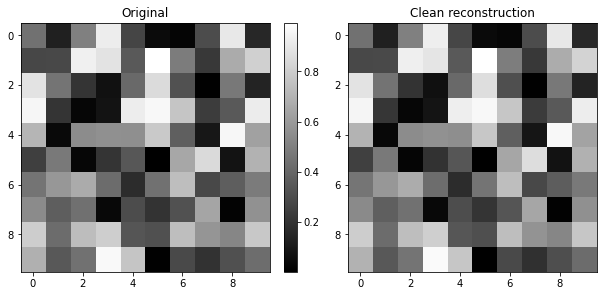

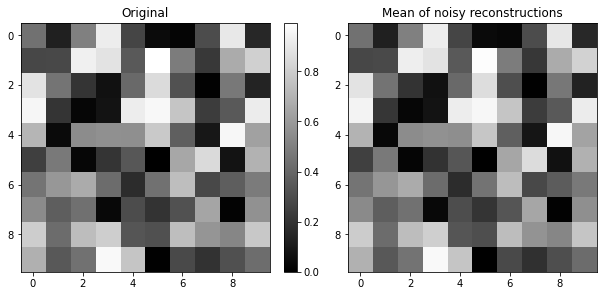

In [75]:
# visually compare original image, cleanly reconstructed image, and
# mean of noisily reconstructed images
orig_img = np.reshape(y_orig, (10,10))
clean_recon_img = np.reshape(results['y_clean_recon'],(10,10))
mean_noisy_img = np.reshape(results['y_noisy_mean'], (10,10))

plot_img_comparison(orig_img, clean_recon_img,
                   left_title='Original', right_title='Clean reconstruction')
plot_img_comparison(orig_img, mean_noisy_img,
                   left_title='Original', right_title='Mean of noisy reconstructions')

### Sample variance, CRLB, and pseudo-CRLB
The sample variance visually resembles both the CRLB and pseudo-CRLB. However, even for noise levels of 0.05, the pseudo-CRLB isn't really a lower bound for the sample variance, even though it is in the vicinity. I think we can tentatively conclude that our assumptions in the beginning were valid, at least for small levels of noise--the fact that the network is biased doesn't seem to be a huge effect, and the variance does seem to achieving the lower bound. Next steps:
1. Calculate the distance of the sample variance from the CRLBs as a function of the noise level.
2. Calculate the correlation between the sample variance and CRLBS as a function of the noise level.
3. Try to estimate the bias factor in the true CRLB by doing some numerical derivatives on `y_noisy_mean`.

In [80]:
# run simulation on a vector in test dataset
y_orig = y_test[1]
results = monte_carlo_noise_sim(y_orig, A, model, noise_lvl=0.05, N=2000)

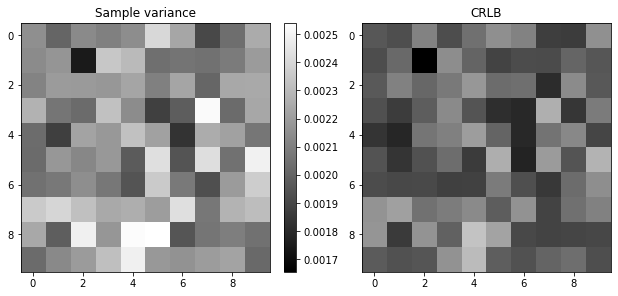

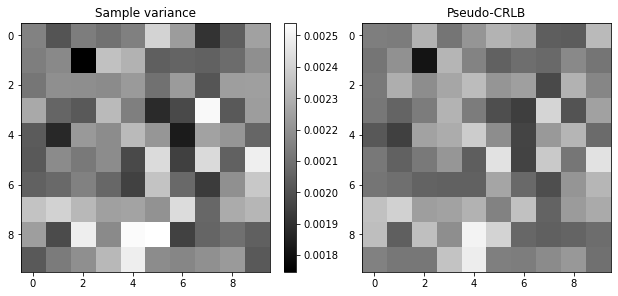

In [81]:
var_img = np.reshape(results['variance'], (10,10))
diag_crlb_img = np.reshape(np.diag(results['crlb']), (10,10))
diag_pseudo_crlb_img = np.reshape(np.diag(results['pseudo_crlb']), (10,10))

plot_img_comparison(var_img, diag_crlb_img,
                    left_title='Sample variance', right_title='CRLB')
plot_img_comparison(var_img, diag_pseudo_crlb_img,
                    left_title='Sample variance', right_title='Pseudo-CRLB')

### Correlation between pseudo-CRLB and pixel-wise sample variance over different input vectors

Define shifted samples $\hat{x_i} = x_i - \mu_x$ and $\hat{y_i} = y_i - \mu_y$ where $\mu_x$
and $\mu_y$ are the means of $x_i$ and $y_i$ respectively. Then
$$ \rho = \frac{\sum_i \hat{x_i} \hat{y_i}}{\sqrt{(\sum_i \hat{x_i}^2) (\sum_i \hat{y_i}^2)}} $$

In [22]:
def correlation(x, y):
    '''Calculate correlation coefficient between two vectors.'''
    centered_x = x - np.mean(x)
    centered_y = y - np.mean(y)
    # perturb denominator by a small epsilon so that a constant series
    # gets a correlation of 0
    # (don't really remember when we were thinking this would be useful/necessary)
    eps = 1e-10
    return np.sum(centered_x * centered_y) \
            / (np.sqrt(np.sum(centered_x**2) * np.sum(centered_y**2)) + eps)

In [23]:
def uncentered_correlation(x, y):
    '''Calculate "uncentered" correlation coefficient, <x,y>/(||x||*||y||)'''
    # perturb denominator by a small epsilon so that a constant series
    # gets a correlation of 0
    # (don't really remember when we were thinking this would be useful/necessary)
    eps = 1e-10
    return np.sum(x*y) / (np.sqrt(np.sum(x**2) * np.sum(y**2)) + eps)

In [25]:
def pixel_correlation(A, B, use_uncentered=False):
    '''
    Calculate correlation coefficients between columns of two matrices.
    
    Each row of A and B is a flattened image, so each column gives how
    a single pixel changes from image to image. 
    
    Arguments:
        A: N row-vectors of length d (Nxd)
        B: ditto
        use_uncentered: set to True if the uncentered correlation is
            desired. Defaults to False.
    '''
    d = A.shape[1] # number of columns, corresponds to image size
    corr_coefs = np.zeros(d)
    for col in range(A.shape[1]):
        if use_uncentered:
            corr_coefs = uncentered_correlation(A[:,col], B[:,col])
        else:
            corr_coefs = correlation(A[:,col], B[:,col])
        
    return corr_coefs